In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
dir = "./data"
SEED = 33
np.random.seed(SEED)


In [3]:
mnist = fetch_openml('Fashion-MNIST')
rawX, rawY = mnist.data, mnist.target
rawX = np.array(rawX)
rawY = np.array(rawY, dtype=int)
assert(len(rawX) == len(rawY))

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [16]:
scaleX = rawX / 255

trainX, testX, trainY, testY = train_test_split(scaleX, rawY, test_size=10000, random_state=42, shuffle=True)

trainX = np.array(trainX)[0:8196]  # Convert to numpy array
testX = np.array(testX)

# Reshape the data
trainX = trainX.reshape((trainX.shape[0], -1))
testX = testX.reshape((testX.shape[0], -1))
trainY = trainY[0:8196]

print("MNIST Training Data shape:", trainX.shape)
print("MNIST Training Labels shape:", trainY.shape)
print("MNIST Testing Data shape:", testX.shape)
print("MNIST Testing Labels shape:", testY.shape)

MNIST Training Data shape: (8196, 784)
MNIST Training Labels shape: (8196,)
MNIST Testing Data shape: (10000, 784)
MNIST Testing Labels shape: (10000,)


In [1]:
class MLP:
    def __init__(
        self,
        inputNeurons=784,
        hiddenNeurons=[],
        outputNeurons=10,
        initialType=4,
        regularizationType=0,
        regularizationStrength=0.001,
        activationType=0,
    ):
        
        self.inputNeurons = inputNeurons
        self.hiddenNeurons = hiddenNeurons
        self.outputNeurons = outputNeurons
        self.regularizationType = regularizationType
        self.activationType = activationType
        self.regularizationStrength = regularizationStrength
        self.w = []
        self.b = []
        numLayers = len(self.hiddenNeurons)
        random_state = np.random.RandomState(0)  # added for reproducibility

        for i, hiddenNeuron in enumerate([self.inputNeurons] + self.hiddenNeurons):
            if i == numLayers:  # last weight layer
                row, column = hiddenNeuron, outputNeurons
            else:  # not last layer
                row, column = hiddenNeuron, self.hiddenNeurons[i]

            if initialType == 0:  # zeros
                self.w.append(np.zeros((row, column)))
                self.b.append(np.zeros(column))
            elif initialType == 1:  # uniform
                self.w.append(random_state.uniform(low=-1, high=1, size=(row, column)))
                self.b.append(np.zeros(column))
            elif initialType == 2:  # gaussian
                self.w.append(random_state.randn(row, column))
                self.b.append(random_state.randn(column))
            elif initialType == 3:  # xavier
                stdX = np.sqrt(1 / (row + column))
                self.w.append(random_state.randn(row, column) * stdX)
                self.b.append(np.zeros(column))
            elif initialType == 4:  # kaiming
                stdK = np.sqrt(2 / row)
                self.w.append(random_state.randn(row, column) * stdK)
                self.b.append(np.zeros(column))

    def ReLU(self, x):
        return np.maximum(x, 0)

    def ReLU_prime(self, x):
        return np.where(x > 0, 1, 0)

    def leakyReLU(self, x, alpha=0.01):
        return np.maximum(x, alpha * x)

    def leakyReLU_prime(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def hyperTan(self, x):
        return np.tanh(x)

    def hyperTan_prime(self, x):
        return 1 - np.tanh(x) ** 2

    def softmax(self, z):
        exp_values = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_values / exp_values.sum(axis=1, keepdims=True)

    def evaluate_acc(self, x, y):
        result = self.predict(x)
        correct = 0
        for res_i, y_i in zip(result, y):
            correct += 1 if res_i == y_i else 0
        return float(correct) / len(y)

    def cross_entropy_loss(self, testX, testY):
        activations = self.feedforward(testX)
        predictions = self.softmax(activations[-1])
        encodeY = self.one_hot_encode(testY)
        loss = -np.sum(encodeY * np.log2(predictions + 1e-10))

        if self.regularizationType == 1:  # l1
            l1_reg = sum([np.sum(np.abs(w_matrix)) for w_matrix in self.w])
            loss += self.regularizationStrength * l1_reg
        elif self.regularizationType == 2:  # l2
            l2_reg = sum([np.sum(np.square(w_matrix)) for w_matrix in self.w])
            loss += self.regularizationStrength * 0.5 * l2_reg
        return loss / len(testY)

    def one_hot_encode(self, y):
        encodedV = []
        for y_i in y:
            encoded = [0] * self.outputNeurons
            encoded[y_i] = 1
            encodedV.append(encoded)
        return encodedV

    def predict(self, X):
        activations = self.feedforward(X)
        predictions = self.softmax(activations[-1])
        result = np.argmax(predictions, axis=1)
        return result

    def feedforward(self, x):

        allLayersActivations = [x]

        for weights, biases in zip(self.w, self.b):
            z = allLayersActivations[-1] @ weights + biases
            if self.activationType == 0:
                x = self.ReLU(z)
            elif self.activationType == 1:
                x = self.leakyReLU(z)
            elif self.activationType == 2:
                x = self.hyperTan(z)

            allLayersActivations.append(x)

        return allLayersActivations

    def backward(self, x, y, activationF, activationFP):
        currLayerActivation = x
        allLayersActivations = [x] # list to store all the activations, layer by layer
        zSigma = []

        numVal, _ = x.shape

        for i in range(len(self.w)):
            rawY = np.dot(currLayerActivation, self.w[i]) + self.b[i]
            zSigma.append(rawY)
            currLayerActivation = activationF(rawY)
            allLayersActivations.append(currLayerActivation)

        deltaDest = self.softmax(allLayersActivations[-1]) - y

        for i in reversed(range(len(self.w))):

            gradW = (
                self.learningRate
                * np.dot(allLayersActivations[i].T, deltaDest)
                / numVal
            )
            gradB = self.learningRate * np.sum(deltaDest, axis=0) / numVal

            # if regularized
            if self.regularizationType == 1: # L1 regularization
                gradW += (self.regularizationStrength / numVal) * np.sign(self.w[i])
            elif self.regularizationType == 2: # L2 regularization
                gradW += (self.regularizationStrength / numVal) * self.w[i]
                
            # Weight update
            self.w[i] -= self.learningRate * gradW
            self.b[i] -= self.learningRate * gradB

            if i == 0 or len(self.w) == 1:
                break

            if i > 0:
                deltaDest = activationFP(zSigma[i - 1]) * np.dot(deltaDest, self.w[i].T)

    def fit(
        self,
        trainX,
        trainY,
        testX,
        testY,
        batchsize=512,
        learningRate=0.01,
        epochs=200,
    ):

        self.learningRate = learningRate
        accuracy = []
        loss = []

        for e in range(epochs):
            for start in range(0, len(trainX), batchsize):
                batchX = trainX[start : start + batchsize]
                batchY = trainY[start : start + batchsize]
                batchY = self.one_hot_encode(batchY)
                if self.activationType == 0:
                    activationF = self.ReLU
                    activationFP = self.ReLU_prime
                elif self.activationType == 1:
                    activationF = self.leakyReLU
                    activationFP = self.leakyReLU_prime
                elif self.activationType == 2:
                    activationF = self.hyperTan
                    activationFP = self.hyperTan_prime
                
                self.backward(batchX, batchY, activationF, activationFP)

            if e % 2 == 0:
                accT = round(self.evaluate_acc(testX, testY), 2) * 100
                accuracy.append(accT)
                lossT = self.cross_entropy_loss(testX, testY)
                loss.append(lossT)
                print("Epoch", e, ":", accT, "%")

        return accuracy, loss


In [ ]:
# small test
model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=3, activationType = 2)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=32,learningRate=0.01, epochs=200)
# print(accuracy)

In [55]:
# epochs array for visualization
epochs = 200
epoch = 0
epoch_array = []

# Creating the epoch array
while epoch <= epochs - 2:
    epoch_array.append(epoch)
    epoch += 2

## Exploring learning rates:

done for 0.005
done for 0.01


/var/folders/_l/t85snlb97nqgpdp7tb0gk1dr0000gn/T/ipykernel_19866/2559356653.py:156: RuntimeWarning: invalid value encountered in multiply
  deltaDest = activationFP(zSigma[i - 1]) * np.dot(deltaDest, self.w[i].T)


done for 0.05
done for 0.1


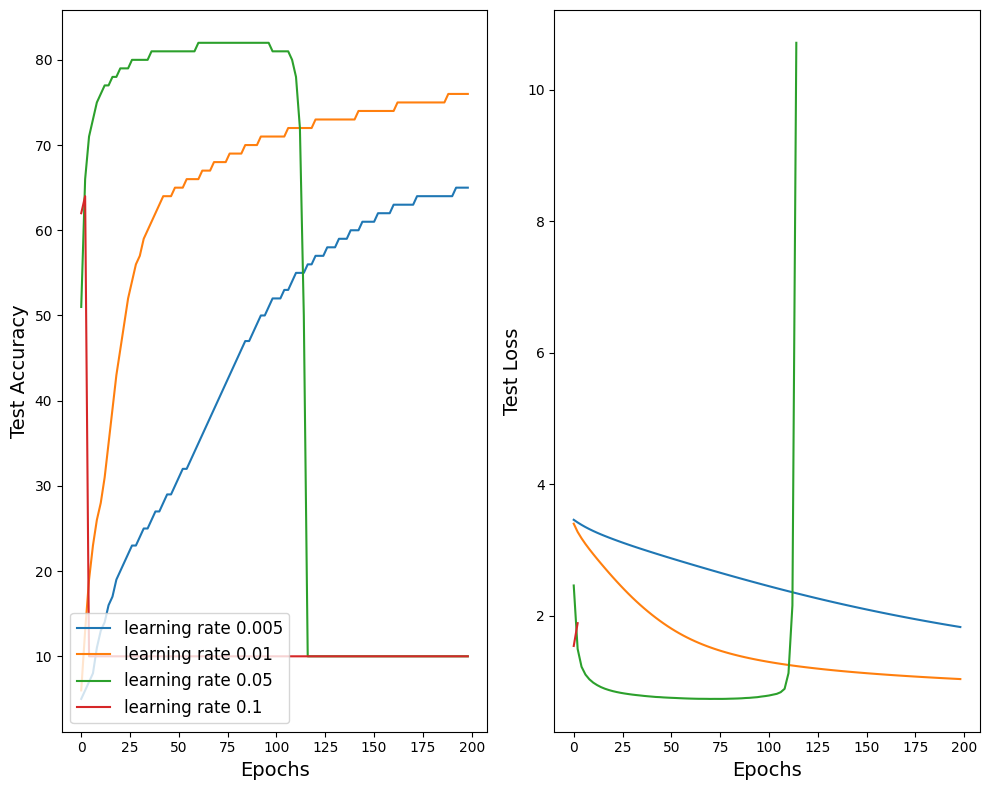

0

In [56]:
plt.figure(figsize=(10, 8))
rates = [0.005, 0.01, 0.05, 0.1]
lossArr = []
accArr = []

for i in range(4):
    model = MLP(inputNeurons=784, hiddenNeurons=[128,128, 128], outputNeurons=10, initialType=4)
    accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=rates[i], epochs=epochs)
    lossArr.append(loss)
    accArr.append(accuracy)
    print("done for", rates[i])
    
plt.subplot(1, 2, 1) 
for i in range(4):
    plt.plot(epoch_array, accArr[i], label=f'learning rate {rates[i]}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

plt.subplot(1, 2, 2)
for i in range(4):
    plt.plot(epoch_array, lossArr[i], label=f'{rates[i]}')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)

plt.tight_layout()
plt.show()

import os
os.system('say "ALERT ALERT I just finished running a model."')



## Task 3 - Part 1

done for all zeros
done for Uniform [-1, 1]
done for Gaussian N(0,1)
done for Xavier
done for Kaiming


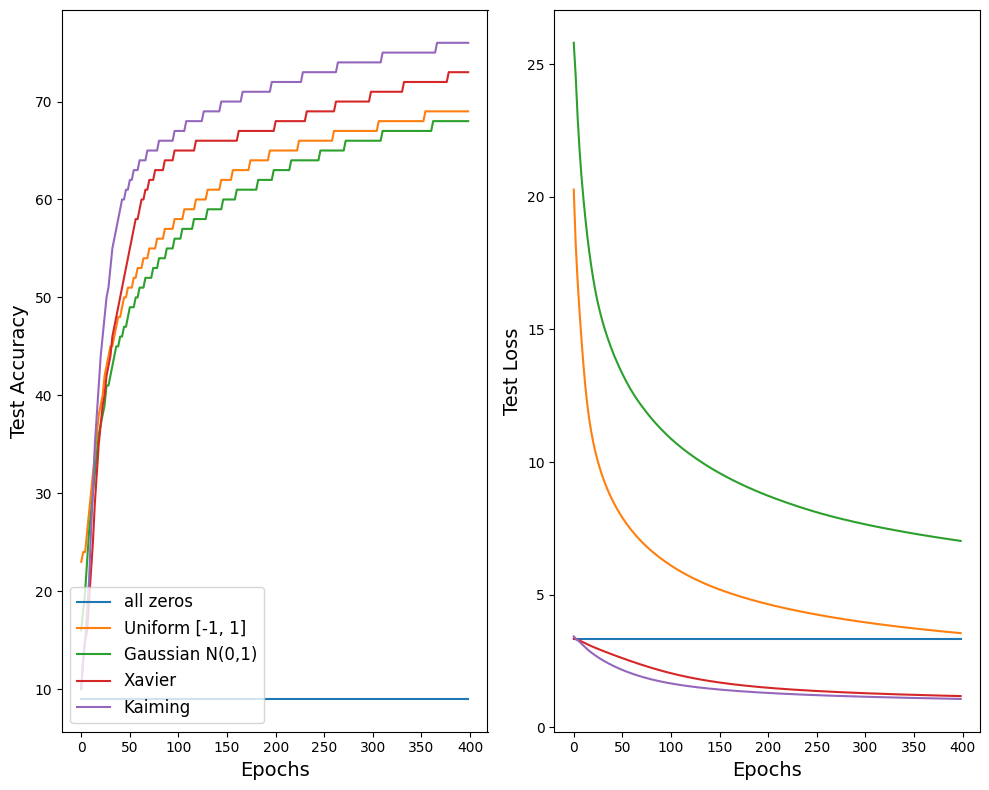

0

In [32]:
plt.figure(figsize=(10, 8))
labels = ["all zeros", "Uniform [-1, 1]", "Gaussian N(0,1)", "Xavier", "Kaiming"]
lossArr = []
accArr = []

for initType in range(5):
    model = MLP(inputNeurons=784, hiddenNeurons=[128], outputNeurons=10, initialType=initType)
    accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
    lossArr.append(loss)
    accArr.append(accuracy)
    print("done for", labels[initType])

plt.subplot(1, 2, 1) 

for initType in range(5):
    plt.plot(epoch_array, accArr[initType], label=f'{labels[initType]}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.legend(loc='lower left', fontsize=12)
plt.subplot(1, 2, 2)

for initType in range(5):
    plt.plot(epoch_array, lossArr[initType], label=f'{labels[initType]}')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
plt.tight_layout()
plt.show()

import os
os.system('say "ALERT ALERT I just finished running a model."')

## Task 3 - Part 2

done for  0 hidden layers
done for 1 hidden layer (128 wide)
done for 2 hidden layers (128 wide)
done for 3 hidden layers (128 wide)


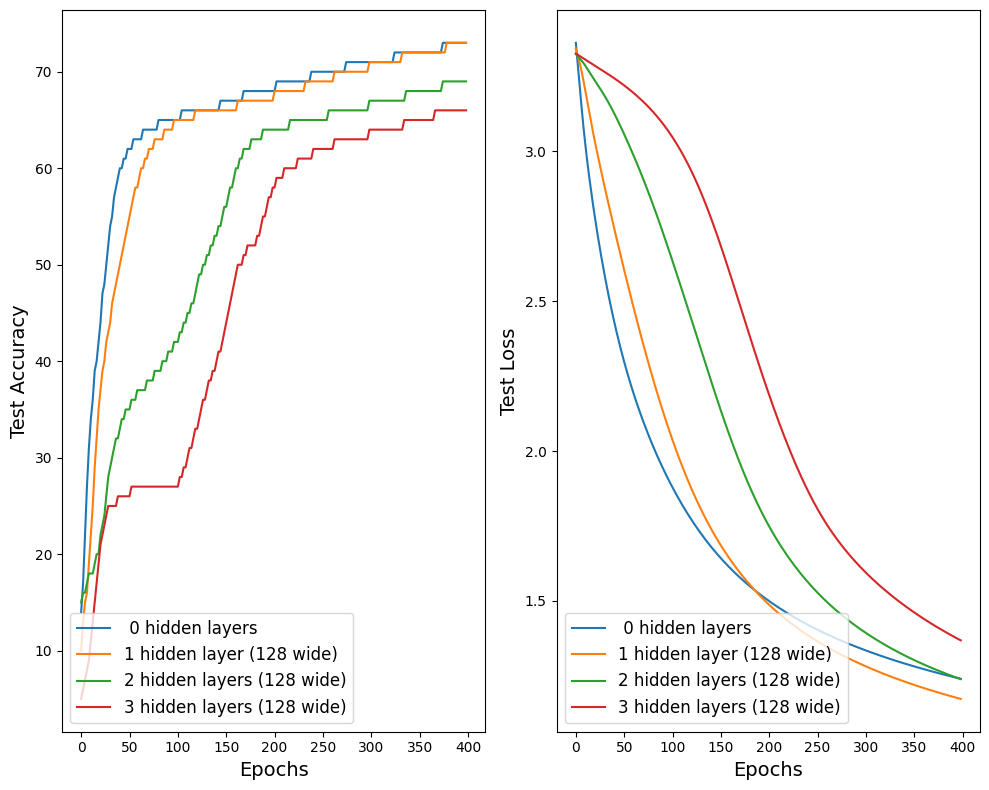

0

In [33]:
plt.figure(figsize=(10, 8))


layers = [[], [128], [128, 128], [128, 128, 128]]
layersLabel = [' 0 hidden layers', '1 hidden layer (128 wide)', '2 hidden layers (128 wide)', '3 hidden layers (128 wide)']
lossArr = []
accArr = []

for layersNum in range(4):
    model = MLP(inputNeurons=784, hiddenNeurons=layers[layersNum], outputNeurons=10, initialType=3)
    accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
    lossArr.append(loss)
    accArr.append(accuracy)
    print("done for", layersLabel[layersNum])
    
    
plt.subplot(1, 2, 1) 
for layersNum in range(4):
    plt.plot(epoch_array, accArr[layersNum], label=f'{layersLabel[layersNum]}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

plt.subplot(1, 2, 2)
for layersNum in range(4):
    plt.plot(epoch_array, lossArr[layersNum], label=f'{layersLabel[layersNum]}')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)

plt.legend(loc='lower left', fontsize=12)

plt.tight_layout()

plt.show()

import os
os.system('say "ALERT ALERT I just finished running a model."')



## Task 3 - Part 3

Epoch 0 : 15.0 %
Epoch 2 : 16.0 %
Epoch 4 : 16.0 %
Epoch 6 : 17.0 %
Epoch 8 : 18.0 %
Epoch 10 : 18.0 %
Epoch 12 : 18.0 %
Epoch 14 : 19.0 %
Epoch 16 : 20.0 %
Epoch 18 : 20.0 %
Epoch 20 : 22.0 %
Epoch 22 : 23.0 %
Epoch 24 : 24.0 %
Epoch 26 : 26.0 %
Epoch 28 : 28.000000000000004 %
Epoch 30 : 28.999999999999996 %
Epoch 32 : 30.0 %
Epoch 34 : 31.0 %
Epoch 36 : 32.0 %
Epoch 38 : 32.0 %
Epoch 40 : 33.0 %
Epoch 42 : 34.0 %
Epoch 44 : 34.0 %
Epoch 46 : 35.0 %
Epoch 48 : 35.0 %
Epoch 50 : 35.0 %
Epoch 52 : 36.0 %
Epoch 54 : 36.0 %
Epoch 56 : 36.0 %
Epoch 58 : 37.0 %
Epoch 60 : 37.0 %
Epoch 62 : 37.0 %
Epoch 64 : 37.0 %
Epoch 66 : 37.0 %
Epoch 68 : 38.0 %
Epoch 70 : 38.0 %
Epoch 72 : 38.0 %
Epoch 74 : 38.0 %
Epoch 76 : 39.0 %
Epoch 78 : 39.0 %
Epoch 80 : 39.0 %
Epoch 82 : 39.0 %
Epoch 84 : 40.0 %
Epoch 86 : 40.0 %
Epoch 88 : 40.0 %
Epoch 90 : 41.0 %
Epoch 92 : 41.0 %
Epoch 94 : 41.0 %
Epoch 96 : 42.0 %
Epoch 98 : 42.0 %
Epoch 100 : 42.0 %
Epoch 102 : 43.0 %
Epoch 104 : 43.0 %
Epoch 106 : 44.0 %
E

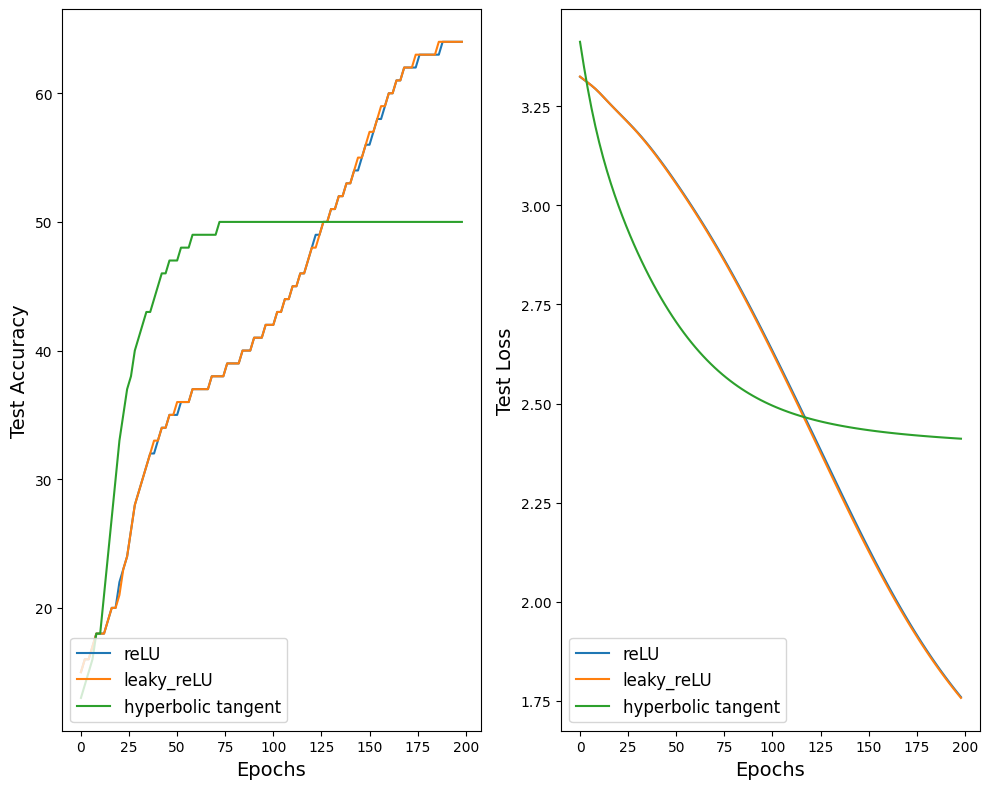

In [24]:
plt.figure(figsize=(10, 8))

accuracyAll = []
lossAll = []

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=3, activationType = 0)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=3, activationType = 1)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=3, activationType = 2)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

activations = ["reLU","leaky_reLU","hyperbolic tangent"]

plt.subplot(1, 2, 1) 
for actType in range(3):
    plt.plot(epoch_array, accuracyAll[actType], label=f'{activations[actType]}')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

plt.subplot(1, 2, 2) 
for actType in range(3):
    plt.plot(epoch_array, lossAll[actType], label=f'{activations[actType]}')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
plt.tight_layout()
plt.legend(loc='lower left', fontsize=12)

plt.tight_layout()
plt.show()

## Task 3 - Part 4

Epoch 0 : 15.0 %
Epoch 2 : 16.0 %
Epoch 4 : 18.0 %
Epoch 6 : 21.0 %
Epoch 8 : 25.0 %
Epoch 10 : 28.999999999999996 %
Epoch 12 : 32.0 %
Epoch 14 : 35.0 %
Epoch 16 : 36.0 %
Epoch 18 : 38.0 %
Epoch 20 : 39.0 %
Epoch 22 : 40.0 %
Epoch 24 : 42.0 %
Epoch 26 : 43.0 %
Epoch 28 : 44.0 %
Epoch 30 : 45.0 %
Epoch 32 : 47.0 %
Epoch 34 : 48.0 %
Epoch 36 : 50.0 %
Epoch 38 : 51.0 %
Epoch 40 : 52.0 %
Epoch 42 : 54.0 %
Epoch 44 : 55.00000000000001 %
Epoch 46 : 56.99999999999999 %
Epoch 48 : 57.99999999999999 %
Epoch 50 : 59.0 %
Epoch 52 : 60.0 %
Epoch 54 : 61.0 %
Epoch 56 : 62.0 %
Epoch 58 : 62.0 %
Epoch 60 : 63.0 %
Epoch 62 : 64.0 %
Epoch 64 : 64.0 %
Epoch 66 : 65.0 %
Epoch 68 : 65.0 %
Epoch 70 : 65.0 %
Epoch 72 : 66.0 %
Epoch 74 : 66.0 %
Epoch 76 : 66.0 %
Epoch 78 : 66.0 %
Epoch 80 : 66.0 %
Epoch 82 : 67.0 %
Epoch 84 : 67.0 %
Epoch 86 : 67.0 %
Epoch 88 : 67.0 %
Epoch 90 : 67.0 %
Epoch 92 : 67.0 %
Epoch 94 : 67.0 %
Epoch 96 : 68.0 %
Epoch 98 : 68.0 %
Epoch 100 : 68.0 %
Epoch 102 : 68.0 %
Epoch 104 : 68

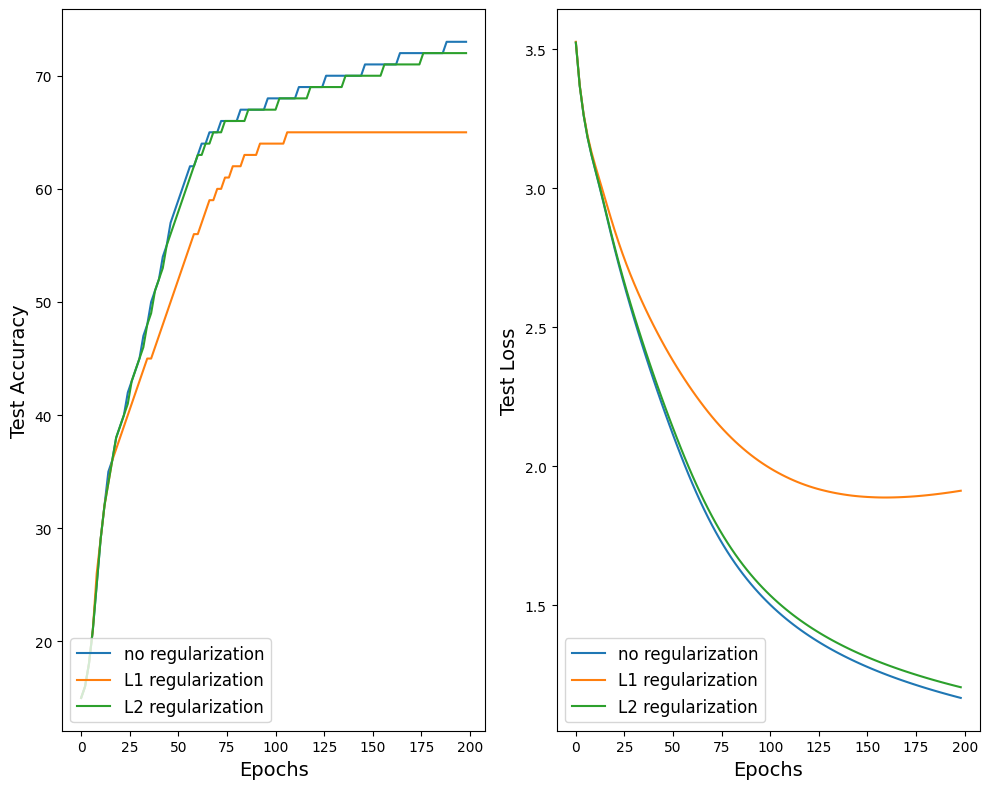

In [17]:
plt.figure(figsize=(10, 8))

accuracyAll = []
lossAll = []
regType = ["no regularization","L1 regularization","L2 regularization"]

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4, regularizationStrength = 0.01, regularizationType=0)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4, regularizationStrength = 0.01, regularizationType=1)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4, regularizationStrength = 0.01, regularizationType=2)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=64,learningRate=0.01, epochs=epochs)
accuracyAll.append(accuracy)
lossAll.append(loss)
print("done")

plt.subplot(1, 2, 1) 
for i in range(3):
    plt.plot(epoch_array, accuracyAll[i], label=f'{regType[i]}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.legend(loc='lower left', fontsize=12)

plt.subplot(1, 2, 2) 
for i in range(3):
    plt.plot(epoch_array, lossAll[i], label=f'{regType[i]}')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Loss', fontsize=14)
plt.tight_layout()
plt.legend(loc='lower left', fontsize=12)
plt.tight_layout()
plt.show()

## Task 3 - Part 5

Epoch 0 : 19.0 %
Epoch 2 : 38.0 %
Epoch 4 : 53.0 %
Epoch 6 : 60.0 %
Epoch 8 : 64.0 %
Epoch 10 : 66.0 %
Epoch 12 : 68.0 %
Epoch 14 : 69.0 %
Epoch 16 : 70.0 %
Epoch 18 : 71.0 %
Epoch 20 : 71.0 %
Epoch 22 : 72.0 %
Epoch 24 : 72.0 %
Epoch 26 : 73.0 %
Epoch 28 : 73.0 %
Epoch 30 : 74.0 %
Epoch 32 : 74.0 %
Epoch 34 : 74.0 %
Epoch 36 : 75.0 %
Epoch 38 : 75.0 %
Epoch 40 : 75.0 %
Epoch 42 : 75.0 %
Epoch 44 : 76.0 %
Epoch 46 : 76.0 %
Epoch 48 : 76.0 %
Epoch 50 : 76.0 %
Epoch 52 : 76.0 %
Epoch 54 : 76.0 %
Epoch 56 : 77.0 %
Epoch 58 : 77.0 %
Epoch 60 : 77.0 %
Epoch 62 : 77.0 %
Epoch 64 : 77.0 %
Epoch 66 : 77.0 %
Epoch 68 : 78.0 %
Epoch 70 : 78.0 %
Epoch 72 : 78.0 %
Epoch 74 : 78.0 %
Epoch 76 : 78.0 %
Epoch 78 : 78.0 %
Epoch 80 : 78.0 %
Epoch 82 : 78.0 %
Epoch 84 : 79.0 %
Epoch 86 : 79.0 %
Epoch 88 : 79.0 %
Epoch 90 : 79.0 %
Epoch 92 : 79.0 %
Epoch 94 : 79.0 %
Epoch 96 : 79.0 %
Epoch 98 : 79.0 %
Epoch 100 : 79.0 %
Epoch 102 : 79.0 %
Epoch 104 : 79.0 %
Epoch 106 : 80.0 %
Epoch 108 : 80.0 %
Epoch 110 

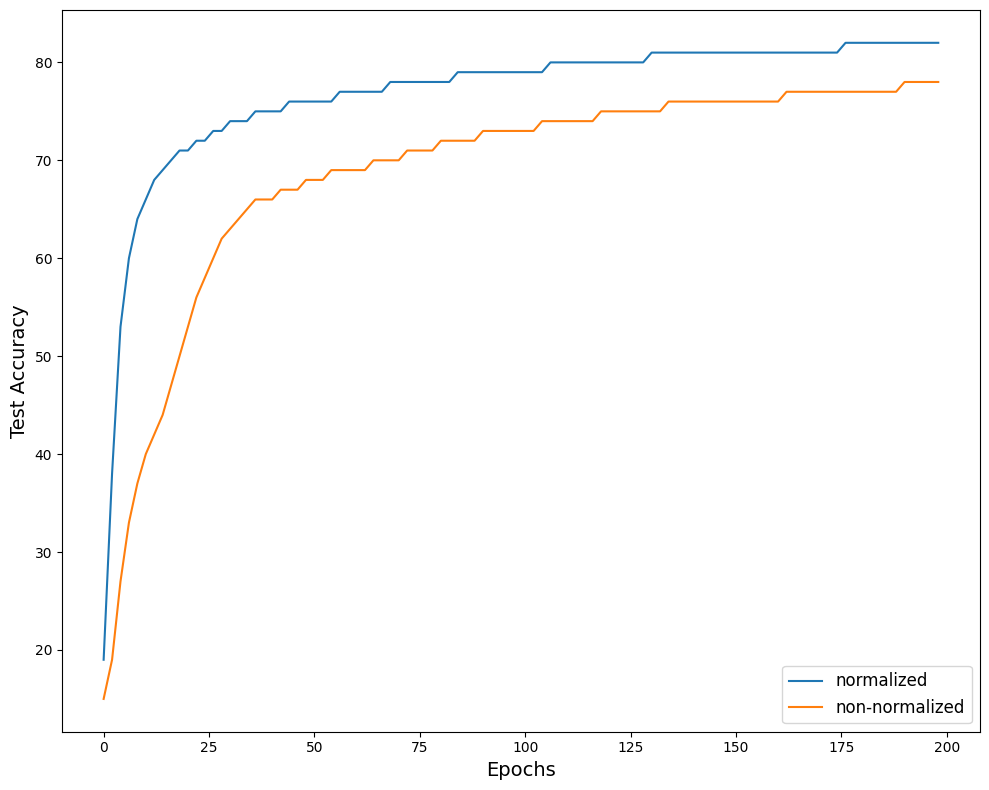

In [13]:
trainX_raw, testX_raw, trainY, testY = train_test_split(rawX, rawY, test_size=10000, random_state=42)

trainX_raw = np.array(trainX_raw)[0:16384]
testX_raw = np.array(testX_raw)

trainX_noNorm = trainX_raw / 255
testX_noNorm = testX_raw / 255

xMean = trainX_noNorm.mean()
xStd = trainX_noNorm.std()

trainX_norm = (trainX_noNorm - xMean) / xStd
testX_norm = (testX_noNorm - xMean) / xStd

trainY_reg = np.array(trainY[0:16384], dtype=int)
testY_reg = np.array(testY, dtype=int)

plt.figure(figsize=(10, 8))

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4, regularizationType=0)
accuracy, _ = model.fit(trainX_norm, trainY_reg, testX_norm, testY_reg, batchsize=64,learningRate=0.01, epochs=epochs)
plt.plot(epoch_array, accuracy, label=f'normalized')
print("done")

model = MLP(inputNeurons=784, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4, regularizationType=0)
accuracy, _ = model.fit(trainX_noNorm, trainY_reg, testX_noNorm, testY_reg, batchsize=64,learningRate=0.01, epochs=epochs)
plt.plot(epoch_array, accuracy, label=f'non-normalized')
print("done")

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.tight_layout()
plt.legend(loc='lower right', fontsize=12)

plt.show()

## Task 3 : Part 7 (CIFAR10 dataset)

In [58]:
from sklearn.datasets import fetch_openml

cifar10 = fetch_openml('CIFAR_10')
rawX, rawY = cifar10.data, cifar10.target
rawX = np.array(rawX)
rawY = np.array(rawY, dtype=int)

scaleX = rawX / 255.0

from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(scaleX, rawY, test_size=10000, random_state=42, shuffle=True)
trainX = np.array(trainX)[0:8196]  # Convert to numpy array and limit the size
testX = np.array(testX)
trainY = trainY[0:8196]

/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:75: RuntimeWarning: Invalid cache, redownloading file
  warn("Invalid cache, redownloading file", RuntimeWarning)
/opt/homebrew/lib/python3.11/site-packages/sklearn/datasets/_openml.py:110: UserWarning: A network error occurred while downloading https://api.openml.org/data/v1/download/16797613. Retrying...
  warn(


CIFAR-10 Training Data shape: (8196, 3072)
CIFAR-10 Training Labels shape: (8196,)
CIFAR-10 Testing Data shape: (10000, 3072)
CIFAR-10 Testing Labels shape: (10000,)


Epoch 0 : 13.0 %
Epoch 2 : 17.0 %
Epoch 4 : 20.0 %
Epoch 6 : 22.0 %
Epoch 8 : 23.0 %
Epoch 10 : 24.0 %
Epoch 12 : 25.0 %
Epoch 14 : 26.0 %
Epoch 16 : 26.0 %
Epoch 18 : 27.0 %
Epoch 20 : 27.0 %
Epoch 22 : 28.000000000000004 %
Epoch 24 : 28.000000000000004 %
Epoch 26 : 28.999999999999996 %
Epoch 28 : 28.999999999999996 %
Epoch 30 : 28.999999999999996 %
Epoch 32 : 28.999999999999996 %
Epoch 34 : 28.999999999999996 %
Epoch 36 : 30.0 %
Epoch 38 : 30.0 %
Epoch 40 : 30.0 %
Epoch 42 : 30.0 %
Epoch 44 : 30.0 %
Epoch 46 : 30.0 %
Epoch 48 : 31.0 %
Epoch 50 : 31.0 %
Epoch 52 : 31.0 %
Epoch 54 : 31.0 %
Epoch 56 : 31.0 %
Epoch 58 : 31.0 %
Epoch 60 : 31.0 %
Epoch 62 : 31.0 %
Epoch 64 : 31.0 %
Epoch 66 : 31.0 %
Epoch 68 : 31.0 %
Epoch 70 : 32.0 %
Epoch 72 : 32.0 %
Epoch 74 : 32.0 %
Epoch 76 : 32.0 %
Epoch 78 : 32.0 %
Epoch 80 : 32.0 %
Epoch 82 : 32.0 %
Epoch 84 : 33.0 %
Epoch 86 : 33.0 %
Epoch 88 : 33.0 %
Epoch 90 : 33.0 %
Epoch 92 : 33.0 %
Epoch 94 : 33.0 %
Epoch 96 : 33.0 %
Epoch 98 : 33.0 %
Epoch 1

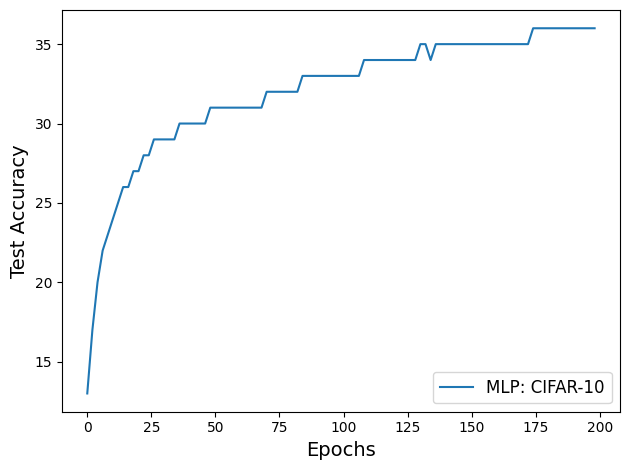

[13.0, 17.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 26.0, 27.0, 27.0, 28.000000000000004, 28.000000000000004, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 28.999999999999996, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 31.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 32.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 33.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 34.0, 35.0, 35.0, 34.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0]


In [65]:
# epochs array for visualization
epochsZ = 200
epoch = 0
epoch_array = []

# Creating the epoch array
while epoch <= epochsZ - 2:
    epoch_array.append(epoch)
    epoch += 2
    
model = MLP(inputNeurons=32*32*3, hiddenNeurons=[128, 128], outputNeurons=10, initialType=4)
accuracy, loss = model.fit(trainX, trainY, testX, testY, batchsize=32,learningRate=0.01, epochs=epochsZ)

plt.plot(epoch_array, accuracy, label=f'MLP: CIFAR-10')
print("done")

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.tight_layout()
plt.legend(loc='lower right', fontsize=12)
plt.show()

print(accuracy)